In [48]:
#imports
# import utils.analysis as analysis
import matplotlib.pyplot as plt
import tifffile as tif
import numpy as np
from tqdm import tqdm
import pandas as pd
# import roifile as roi
from read_roi import read_roi_zip as co_zip
import cv2

In [49]:
image_path = '/Users/aichah/Desktop/TLI/data/cntrl/220511_TLI_cntl_P56_S01_B5B_Fh_R40_N1_Td_GFP_seg.tif'
# cols_path = '/Users/aichah/Desktop/TLI/data/cols/T4-4 (subtype B)/Aicha/T4_4b_FlipV_R20_Cols_1.tif'
Roi_path = '/Users/aichah/Desktop/TLI/data/cntrl/220511_TLI_cntl_P56_S01_B5B_Fh_R80_N1_Td_ColROIs.zip'
save_path = '/Users/aichah/Desktop/TLI/data/cntrl/'
save_name = '220511_TLI_cntl_P56_S01_B5B_Fh_R40_N1_Td_GFP1_test'

##
# entry_point = (0,38,185,225) #entry point of the neuron (T,Z,Y,X), where Z=0

if save_path[-1] != '/':
    save_path += '/'

In [50]:
image = tif.imread(image_path)
# Cols = tif.imread(cols_path)
cols_zip = rois = co_zip(Roi_path)
neuron = image.copy()

In [51]:
neuron.min(), np.quantile(neuron,0.99), neuron.mean(), neuron.max()

(0.0, 0.0, 0.003105291, 1.0)

In [52]:
neuron[neuron>0] = 1
# Cols[Cols>0] = 1

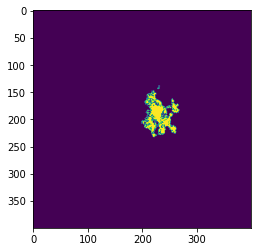

In [53]:
plt.imshow(neuron[15])

In [54]:
neuron.sum()

37490.0

In [55]:
# neuron = neuron[np.newaxis,:]
# neuron.shape

In [68]:
cols_zip.keys()

odict_keys(['1_00', '2_+10', '3_+1+1', '4_0+1', '5_-10', '6_-1-1', '7_0-1', 'B_+2+1', 'D_+1+2', 'A_+20', 'G_-20', 'F_-1+1', 'H_-2-1', 'J_-2-1', 'E_0+2', 'L_+1-1', 'K_0-2', 'C_+2+2', 'I_-2-2'])

In [31]:
# rois = np.array(list(zip(cols_zip['C']['x'],cols_zip['C']['y'])))
# rois = rois.astype(int)
# test = np.zeros([1024,1024])
# test = cv2.fillPoly(test, pts =[rois], color=(255,255,255))
# plt.imshow(test)

In [32]:
# test[test>0]  = 1

In [42]:
def col_occupancy(neuron, cols_zip, normalize=True, plot=True, save=True, save_path='', save_file=''):
    cols_occ = {}
    for key, val in tqdm(cols_zip.items()):
        if val['type'] == 'oval':
            x0 = val['left']+int(val['width']/2); a = int(val['width']/2)  # x center, half width                                       
            y0 = val['top']+int(val['height']/2); b = int(val['height']/2)  # y center, half height                                      
            x = np.linspace(0, neuron.shape[-2],neuron.shape[-1])  # x values of interest
            y = np.linspace(0, neuron.shape[-2],neuron.shape[-1])[:,None]  # y values of interest, as a "column" array
            column = ((x-x0)/a)**2 + ((y-y0)/b)**2 <= 1  # True for points inside the ellipse
            column = column.astype(int)
        elif val['type'] == 'freehand':
            rois = np.array(list(zip(val['x'],val['y'])))
            rois = rois.astype(int)
            column = np.zeros([neuron.shape[-2],neuron.shape[-1]])
            column = cv2.fillPoly(column, pts =[rois], color=(255,255,255))
            column[column>0] = 1
        col_filter = np.broadcast_to(column, neuron.shape)
        # filter = filter.copy()
        # filter -= filter.min()
        # filter = filter/filter.max()
        col_size = col_filter.sum()
        nue_sub = col_filter * neuron # pixels occupied by neuron in the column
        cols_occ[key] = nue_sub.sum()/col_size
    cols_occ = pd.Series(cols_occ)
    if normalize:
        cols_occ = cols_occ/cols_occ.max()
    if save == True:
        if save_file == '':
            save_file = "col_occupancy.csv"
        csv_file = save_path+save_file
        if '.csv' not in csv_file:
            csv_file +='.csv'
        cols_occ.to_csv(csv_file, sep=';')

    return cols_occ

In [34]:
T4_4b_Cols_Ai = col_occupancy(neuron, cols_zip, normalize=True, plot=True, save=True, save_path=save_path, save_file=save_name)

100%|██████████| 21/21 [00:00<00:00, 55.69it/s]


In [35]:
neuron.sum()

57026.0

In [ ]:
rois = np.array(list(zip(cols_zip['2']['x'],cols_zip['2']['y'])))
rois = rois.astype(int)
test = np.zeros([1024,1024])
test = cv2.fillPoly(test, pts =[rois], color=(255,255,255))
plt.imshow(test)

In [68]:
def col_occupancy(neuron, cols, plot=True, save=True, save_path='', save_file=''):
    cols_hist = {}
    ind = 0
    for col in tqdm(cols, desc='calculating Col occupancy', leave=False):
        ind += 1
        cols_hist['col_'+str(ind)] = []
        filter = np.broadcast_to(col, neuron.shape)
        filter = filter.copy()
        filter -= filter.min()
        filter = filter/filter.max()
        col_size = filter.sum()
        nue_sub = filter * neuron # pixels occupied by neuron in the column
        # for t in tqdm(nue_sub, leave=False):
        cols_hist['col_'+str(ind)].append(nue_sub.sum()/col_size)
    #convert the results to dataframe
    occupancy = pd.DataFrame(cols_hist)  
    # if save_path != '' and save_path[-1] != '/':
    #     save_path += '/'
    # if plot:
    #     fig_name = save_path+save_file+'_col_occupancy.pdf'
    #     #ploting the results
    #     plt.figure(figsize=(8, 6), dpi=80)
    #     cols = list(cols_hist.keys())
    #     for col in cols:
    #         plt.plot(occupancy.timepoints, occupancy[col], label=col)
    #     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #     plt.title('Column Occupancy')
    #     plt.ylabel("\n".join(wrap('Column Occupancy [a.u.]',30)))
    #     plt.xlabel("Hours After Puparium Formation [h]")
    #     plt.savefig(fig_name, bbox_inches='tight')
    
    # if save == True:
    #     if save_file == '':
    #         save_file = "col_occupancy.csv"
    #     csv_file = save_path+save_file
    #     if '.csv' not in csv_file:
    #         csv_file +='.csv'
    #     occupancy.to_csv(csv_file, sep=';')
    return occupancy

In [69]:
T4_4b_Cols_Ai = col_occupancy(neuron, Cols, plot=True, save=True, save_path='', save_file='')

calculating Col occupancy:  95%|█████████▌| 19/20 [00:06<00:00,  3.23it/s]/var/folders/5d/tj6rj8cn7_xdplpgkz202g5rnq_4v2/T/ipykernel_30202/3240750036.py:10: RuntimeWarning: invalid value encountered in true_divide
  filter = filter/filter.max()


In [70]:
T4_4b_Cols_Ai

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20
0,0.985699,0.969371,0.980607,0.960109,0.980025,0.935903,0.940126,0.899597,0.893014,0.957344,0.870015,0.875321,0.905705,0.927187,0.931213,0.933284,0.93046,0.935005,0.922964,NaN


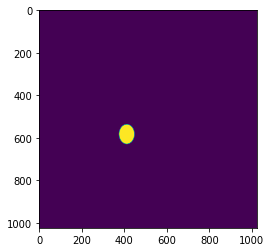

In [81]:
import numpy as np
from matplotlib import pyplot

x0 = 376+int(73/2); a = int(73/2)  # x center, half width                                       
y0 = 537+int(92/2); b = int(92/2)  # y center, half height                                      
x = np.linspace(0, 1024, 1024)  # x values of interest
y = np.linspace(0, 1024, 1024)[:,None]  # y values of interest, as a "column" array
ellipse = ((x-x0)/a)**2 + ((y-y0)/b)**2 <= 1  # True for points inside the ellipse

pyplot.imshow(ellipse)

In [50]:
neuron[neuron>0] = 1
neuron.max()

1

In [53]:
filter = np.broadcast_to(ellipse, neuron.shape)
filter = filter.copy()
filter.max()

True

In [55]:
filter = np.broadcast_to(ellipse, neuron.shape)
filter = filter.copy()
filter[filter==True] = 1
# filter -= filter.min()
# filter = filter/filter.max()
col_size = filter.sum()
nue_sub = filter * neuron # pixels occupied by neuron in the column

In [57]:
nue_sub.shape

(51, 1024, 1024)

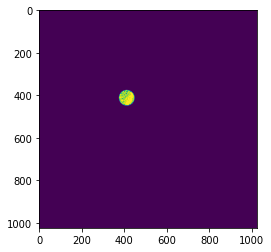

In [59]:
plt.imshow(nue_sub[30])

In [49]:
neuron[neuron>0] = 1
test = neuron.sum()
test = test*ellipse
test.max()

42730066

In [45]:
test = neuron.sum()
test[ellipse==False] = 0
plt.imshow(test)

TypeError: 'numpy.uint64' object does not support item assignment

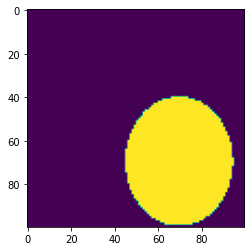

In [33]:
import numpy as np
from matplotlib import pyplot

x0 = 4; a = 5  # x center, half width                                       
y0 = 2; b = 3  # y center, half height                                      
x = np.linspace(-10, 10, 100)  # x values of interest
y = np.linspace(-5, 5, 100)[:,None]  # y values of interest, as a "column" array
ellipse = ((x-x0)/a)**2 + ((y-y0)/b)**2 <= 1  # True for points inside the ellipse

pyplot.imshow(ellipse)

In [27]:
cols_zip

OrderedDict([('0047-0583-0412',
              {'type': 'oval',
               'left': 376,
               'top': 537,
               'width': 73,
               'height': 92,
               'name': '0047-0583-0412',
               'position': {'channel': 0, 'slice': 24, 'frame': 1}}),
             ('0047-0479-0407',
              {'type': 'oval',
               'left': 371,
               'top': 433,
               'width': 73,
               'height': 92,
               'name': '0047-0479-0407',
               'position': {'channel': 0, 'slice': 24, 'frame': 1}}),
             ('0047-0526-0476',
              {'type': 'oval',
               'left': 440,
               'top': 480,
               'width': 73,
               'height': 92,
               'name': '0047-0526-0476',
               'position': {'channel': 0, 'slice': 24, 'frame': 1}}),
             ('0047-0627-0507',
              {'type': 'oval',
               'left': 471,
               'top': 581,
               'width': 

In [17]:
neuron.shape, Cols.shape

((51, 1024, 1024), (512, 512))

In [ ]:
def col_occupancy(neuron, cols, nor_fact=1, start_t=36, plot=True, save=True, save_path='', save_file=''):
    cols_hist = {}
    ind = 0
    for col in tqdm(rang
    for col in tqdm(cols, desc='calculating Col occupancy', leave=False):
        ind += 1
        cols_hist['col_'+str(ind)] = []
        filter = np.broadcast_to(col, neuron.shape)
        filter = filter.copy()
        filter -= filter.min()
        filter = filter/filter.max()
        col_size = filter.sum()
        nue_sub = filter * neuron # pixels occupied by neuron in the column
        for t in tqdm(nue_sub, leave=False):
            cols_hist['col_'+str(ind)].append(t.sum()/col_size)
    #convert the results to dataframe
    occupancy = pd.DataFrame(cols_hist)  
    # definning timepoints
    T_length = np.arange(len(cols_hist[list(cols_hist.keys())[0]]))
    occupancy['timepoints'] = [start_t+(i*0.25) for i in range(0,len(occupancy.index))] 
    if save_path != '' and save_path[-1] != '/':
        save_path += '/'
    if plot:
        fig_name = save_path+save_file+'_col_occupancy.pdf'
        #ploting the results
        plt.figure(figsize=(8, 6), dpi=80)
        cols = list(cols_hist.keys())
        for col in cols:
            plt.plot(occupancy.timepoints, occupancy[col], label=col)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.title('Column Occupancy')
        plt.ylabel("\n".join(wrap('Column Occupancy [a.u.]',30)))
        plt.xlabel("Hours After Puparium Formation [h]")
        plt.savefig(fig_name, bbox_inches='tight')
    
    if save == True:
        if save_file == '':
            save_file = "col_occupancy.csv"
        csv_file = save_path+save_file
        if '.csv' not in csv_file:
            csv_file +='.csv'
        occupancy.to_csv(csv_file, sep=';')
    return occupancy